In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [34]:
df = pd.read_csv("iot_sensor_data.csv", parse_dates=['timestamp'])
df.head(5)

,timestamp,temperature,door_status,energy_usage
0,2025-07-18 12:00:00,4.1,closed,0.42
1,2025-07-18 12:01:00,4.2,open,0.57
2,2025-07-18 12:02:00,4.3,closed,0.40
3,2025-07-18 12:03:00,4.3,closed,0.39
4,2025-07-18 12:04:00,4.4,open,0.60


In [35]:
df = df.sort_values('timestamp')
df.head(5)

,timestamp,temperature,door_status,energy_usage
0,2025-07-18 12:00:00,4.1,closed,0.42
1,2025-07-18 12:01:00,4.2,open,0.57
2,2025-07-18 12:02:00,4.3,closed,0.40
3,2025-07-18 12:03:00,4.3,closed,0.39
4,2025-07-18 12:04:00,4.4,open,0.60


In [36]:
df['door_status'] = df['door_status'].map({'closed':0, 'open': 1})
df.dropna()
df.head(5)

,timestamp,temperature,door_status,energy_usage
0,2025-07-18 12:00:00,4.1,0,0.42
1,2025-07-18 12:01:00,4.2,1,0.57
2,2025-07-18 12:02:00,4.3,0,0.40
3,2025-07-18 12:03:00,4.3,0,0.39
4,2025-07-18 12:04:00,4.4,1,0.60


In [37]:
features = ['temperature', 'door_status', 'energy_usage']
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])
df_scaled.shape

(10, 3)

In [38]:
def create_sequences(data, seq_length=60, forecast_horizon=60):
    X, y = [], []
    for i in range(len(data)-seq_length-forecast_horizon):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+forecast_horizon, 0])  # temperature only
    return np.array(X), np.array(y)

In [39]:
sequence_length = 3  
forecast_horizon = 2  

X, y = create_sequences(df_scaled, sequence_length, forecast_horizon)
print("X shape:", X.shape)  
print("y shape:", y.shape) 


X shape: (5, 3, 3)
y shape: (5, 2)


In [44]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

In [41]:
class LSTMForecast(nn.Module):
    def __init__(self, input_size, hidden_size, forecast_horizon):
        super(LSTMForecast, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    def forward(self, x):
        # x shape: (batch_size, time_steps, input_size)
        _, (h_n, _) = self.lstm(x)       # h_n shape: (1, batch, hidden_size)
        out = self.fc(h_n.squeeze(0))    # output shape: (batch, forecast_horizon)
        return out

In [45]:
X.shape[2]

3

Epoch 1/10, Loss: 0.4410
Epoch 2/10, Loss: 0.4806
Epoch 3/10, Loss: 0.3844
Epoch 4/10, Loss: 0.4229
Epoch 5/10, Loss: 0.3949
Epoch 6/10, Loss: 0.3067
Epoch 7/10, Loss: 0.5324
Epoch 8/10, Loss: 0.3450
Epoch 9/10, Loss: 0.4237
Epoch 10/10, Loss: 0.3897


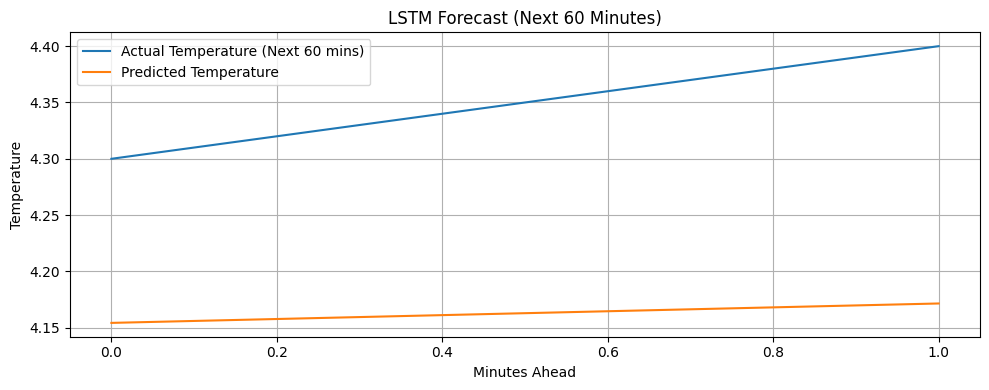

In [48]:
input_size = X.shape[2]
hidden_size = 64
model = LSTMForecast(input_size, hidden_size, forecast_horizon)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    model.train()
    epoch_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader):.4f}")

model.eval()
with torch.no_grad():
    sample_input = X_tensor[0].unsqueeze(0)  # shape: (1, 60, 3)
    prediction = model(sample_input).squeeze().numpy()  # shape: (60,)
    actual = y_tensor[0].numpy()


# Inverse scale only temperature
forecast_horizon = y.shape[1]  # auto-detects 2
temp_index = 0

pred_scaled = np.zeros((forecast_horizon, 3))
true_scaled = np.zeros((forecast_horizon, 3))

pred_scaled[:, temp_index] = prediction
true_scaled[:, temp_index] = actual

# Inverse transform just temperature
pred_temp = scaler.inverse_transform(pred_scaled)[:, temp_index]
true_temp = scaler.inverse_transform(true_scaled)[:, temp_index]

plt.figure(figsize=(10, 4))
plt.plot(true_temp, label="Actual Temperature (Next 60 mins)")
plt.plot(pred_temp, label="Predicted Temperature")
plt.title("LSTM Forecast (Next 60 Minutes)")
plt.xlabel("Minutes Ahead")
plt.ylabel("Temperature")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()